In [1]:
import glob

run_number    = "4708_old"
run_number_db = 4708
outputfolder = "/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps/MonitorPlots/".format(run_number_db)
outputfolder_old = "/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps/MonitorPlots/".format(run_number)
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps/pmaps*.[0-9][0-9][0-9]_*.root.h5".format(run_number_db))
inputfiles_old = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps/pmaps*.[0-9][0-9][0-9]_*.root.h5".format(run_number))

In [2]:
import os
import functools
import itertools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.filters.s1s2_filter as s1s2filt
import invisible_cities.database.load_db as dbf
import invisible_cities.io.table_io as tbiof
import invisible_cities.reco.tbl_functions as tbf
import invisible_cities.io.pmap_io as pmapio
import invisible_cities.reco.pmaps_functions_c  as pmapsfc

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import labels

from invisible_cities.core.system_of_units_c import units

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

Running on  Mon Oct  2 12:20:31 2017


In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Load database

In [4]:
DataSiPM = dbf.DataSiPM(run_number_db)

## Functions

#### Function for some histo stats (mean and std)

In [5]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return [average, np.sqrt(variance)]

#### Functions for filling variables

In [6]:
def fillSvar (evt, s_file, sn, sw, sh, se, st, evt_ts, timestamp):
    try: 
        s = s_file[evt]
    except:
        sn.append(0)   
    else:
        peaks = s.peak_collection()
        sn.append(len(peaks))
        for npeak in peaks:
            peak = s.peak_waveform(npeak)
            sw.append(peak.width)
            sh.append(peak.height)
            se.append(np.sum(peak.E))
            st.append(np.mean(peak.t))
            evt_ts.append(timestamp)

In [7]:
def fillS2PMTvar (s2pmt, sw, sh, se, st, npmt):
    peaks = s2pmt.peak_collection()
    
    for npeak in peaks:
        sw_pmt = []
        sh_pmt = []
        se_pmt = []
        st_pmt = []
        for pmt in np.arange(0,npmt,1):
            peak = s2pmt.pmt_waveform(npeak,pmt)
            sw_pmt.append(peak.width)
            sh_pmt.append(peak.height)
            se_pmt.append(np.sum(peak.E))
            st_pmt.append(np.mean(peak.t))
        sw.append(sw_pmt)
        sh.append(sh_pmt)
        se.append(se_pmt)
        st.append(st_pmt)

In [8]:
def fillS2var (evt, s2_file, s2si_file, s2n, s2w, s2h, s2e, s2t, \
               s2sin, s2q, s2siID, s2qi, s2qmax, s2nsipm, s2_s2si_e,\
               s1n, s1e, s1t, s2_s1_e, s2_s1_t, onlyS1, \
               evt_tS2, evt_tS2si, evt_tS2sin, timestamp):

    s2 = s2_file[evt]
    peaks = s2.peak_collection()
    s2n.append(len(peaks))
    try:
        s2si = s2si_file[evt]       
    except:
        s2sin.append(0)
    else:
        s2sin.append(len(s2si.s2sid))

    for npeak in peaks:
        peak = s2.peak_waveform(npeak)
        
        s2w.append(peak.width)
        s2h.append(peak.height)
        e = np.sum(peak.E)
        s2e.append(e)
        s2t.append(np.mean(peak.t))
        evt_tS2.append(timestamp)
        
        if(s1n[-1]==1):
            s2_s1_e.append(s2e[-1]/s1e[-1])
            s2_s1_t.append(s2t[-1] - s1t[-1])
            onlyS1.append(True)
        else:
            onlyS1.append(False)
        
        q = 0
        try: 
            sipeaks = s2si.s2sid[npeak]
        except:
            pass
        else:
            evt_tS2si.append(timestamp)
            chargemax = -10000

            for ID, si in sipeaks.items():
                evt_tS2sin.append(timestamp)
                charge = np.sum(si)
                q += charge
                s2qi.append(charge)
                s2siID.append(ID)
                if charge>chargemax :
                    chargemax = charge
                
            s2q.append(q)
            s2qmax.append(chargemax)
            s2nsipm.append(len(sipeaks))
        s2_s2si_e.append(q/e)


#### Functions for plotting

In [9]:
def plotVar (var, bins, var_min, var_max, x_label, y_label, title, new_figure = True, log = False):
    n, x, y = hist(var, bins, [var_min, var_max], new_figure = new_figure, alpha = 0.5)
    labels(x_label, y_label, title)
    mean = weighted_std(x, n)
    ypos_text = 0.85*np.max(n)

    if log:
        plt.yscale("log")
    
#    fig.savefig(outputfolder+title+".pdf")
    

In [10]:
def plotVarPMT (npmt, var, bins, var_min, var_max, x_label, y_label, title):
    fsize = 30
    
    n_row = 3
    nrows = npmt//n_row

    if npmt%n_row>0:
        nrows +=1
        
    fig, axes = plt.subplots(nrows, 3, figsize=(40,40))
    st = fig.suptitle(title, fontsize = 80)

    for pmt in range(npmt):
        axes[pmt//n_row][pmt%n_row].hist(var[:,pmt], bins, [var_min, var_max])
        axes[pmt//n_row][pmt%n_row].set_xlabel(x_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_ylabel(y_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_title("PMT {}".format(pmt), fontsize = fsize)

    fig.tight_layout()
    
    st.set_y(0.98)
    fig.subplots_adjust(top=0.93)
    
#    fig.savefig(outputfolder+title+"PMTs.pdf")
    

In [11]:
def plot2dVar(var1, var2, binx, biny, var1_min, var1_max, var2_min, var2_max, x_label, y_label, title, log = False):
    if log == True:
        hist2d(var1, var2, (binx, biny), [[var1_min, var1_max], [var2_min, var2_max]], norm = LogNorm())
    else:
        hist2d(var1, var2, (binx, biny), [[var1_min, var1_max], [var2_min, var2_max]])

    plt.colorbar().set_label("Entries")
    labels(x_label, y_label, title)
    
#    fig.savefig(outputfolder+title+".pdf")

In [12]:
def plot2dVarPMT(npmt, var1, var2, binx, biny, var1_min, var1_max, var2_min, var2_max, x_label, y_label, title):
    fsize = 30
    
    n_row = 3
    nrows = npmt//n_row

    if npmt%n_row>0:
        nrows +=1
        
    fig, axes = plt.subplots(nrows, 3, figsize=(40,40))
    st = fig.suptitle(title, fontsize = 80)

    for pmt in range(npmt):
        axes[pmt//n_row][pmt%n_row].hist2d(var1, var2[:,pmt], (binx, biny), [[var1_min, var1_max], [var2_min, var2_max]])
        axes[pmt//n_row][pmt%n_row].set_xlabel(x_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_ylabel(y_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_title("PMT {}".format(pmt), fontsize = fsize)

    fig.tight_layout()
    
    st.set_y(0.98)
    fig.subplots_adjust(top=0.93)
    
#    fig.savefig(outputfolder+title+"PMTs.pdf")

In [13]:
def CreatePlotsS(sn, sw, sh, se, st, sn_o, sw_o, sh_o, se_o, st_o, stype, smin, smax):

    ### Number of peaks
    plotVar(sn, 10, 0, 10, "# " + stype, "Entries", stype + " number")
    plotVar(sn_o, 10, 0, 10, "# " + stype, "Entries", stype + " number", new_figure = False)

    ### Width
    plotVar(sw, 100, sw.min(), sw.max(), "Width (ns)", "Entries", stype + " width", log = True)
    plotVar(sw_o, 100, sw.min(), sw.max(), "Width (ns)", "Entries", stype + " width", new_figure = False, log = True)

    plotVar(sw, 100, smin['w'], smax['w'], "Width (ns)", "Entries", stype + " width (zoom)")
    plotVar(sw_o, 100, smin['w'], smax['w'], "Width (ns)", "Entries", stype + " width (zoom)", new_figure = False)

    ### Height
    plotVar(sh, 100, sh.min(), sh.max(), "Height (pes)", "Entries", stype + " height", log = True)
    plotVar(sh_o, 100, sh.min(), sh.max(), "Height (pes)", "Entries", stype + " height", new_figure = False, log = True)

    plotVar(sh, 100, smin['h'], smax['h'], "Height (pes)", "Entries", stype + " height (zoom)")
    plotVar(sh_o, 100, smin['h'], smax['h'], "Height (pes)", "Entries", stype + " height (zoom)", new_figure = False)

    ### Energy
    plotVar(se, 100, se.min(), se.max(), "Energy (pes)", "Entries", stype + " energy", log = True)
    plotVar(se_o, 100, se.min(), se.max(), "Energy (pes)", "Entries", stype + " energy", new_figure = False, log = True)

    plotVar(se, 100, smin['e'], smax['e'], "Energy (pes)", "Entries", stype + " energy (zoom)")
    plotVar(se_o, 100, smin['e'], smax['e'], "Energy (pes)", "Entries", stype + " energy (zoom)", new_figure = False)
    
    ### Time position
    plotVar(st, 100, st.min(), st.max(), "Time ($\mu$s)", "Entries", stype + " time position")
    plotVar(st_o, 100, st.min(), st.max(), "Time ($\mu$s)", "Entries", stype + " time position", new_figure = False)

In [14]:
def CreatePlotsSi(sn, q, ID, qi, qimax, nsipm, sn_o, q_o, ID_o, qi_o, qimax_o, nsipm_o, smin, smax):
    ### Number of peaks
    plotVar(sn, 10, 0, 10, "# S2Si", "Entries", "S2Si number")
    plotVar(sn_o, 10, 0, 10, "# S2Si", "Entries", "S2Si number", new_figure = False)
    
    ### Charge
    plotVar(q, 100, q.min(), q.max(), "Total charge (pes)", "Entries", "S2Si charge", log = True)
    plotVar(q_o, 100, q.min(), q.max(), "Total charge (pes)", "Entries", "S2Si charge", new_figure = False, log = True)

    plotVar(q, 100, smin['q'], smax['q'], "Total charge (pes)", "Entries", "S2Si charge (zoom)")
    plotVar(q_o, 100, smin['q'], smax['q'], "Total charge (pes)", "Entries", "S2Si charge (zoom)", new_figure = False)

    ### SiPM charge
    plotVar(qi, 100, qi.min(), qi.max(), "SiPM charge (pes)", "Entries", "SiPM charge", log = True)
    plotVar(qi_o, 100, qi.min(), qi.max(), "SiPM charge (pes)", "Entries", "SiPM charge", new_figure = False, log = True)

    plotVar(qi, 100, smin['qi'], smax['qi'], "SiPM charge (pes)", "Entries", "SiPM charge (zoom)")
    plotVar(qi_o, 100, smin['qi'], smax['qi'], "SiPM charge (pes)", "Entries", "SiPM charge (zoom)", new_figure = False)    
    
    ### SiPM max charge
    plotVar(qimax, 100, qimax.min(), qimax.max(), "SiPM max charge (pes)", "Entries", "SiPM max charge", log = True)
    plotVar(qimax_o, 100, qimax.min(), qimax.max(), "SiPM max charge (pes)", "Entries", "SiPM max charge", new_figure = False, log = True)

    plotVar(qimax, 100, smin['qimax'], smax['qimax'], "SiPM max charge (pes)", "Entries", "SiPM max charge (zoom)")
    plotVar(qimax_o, 100, smin['qimax'], smax['qimax'], "SiPM max charge (pes)", "Entries", "SiPM max charge (zoom)", new_figure = False)
    
    ### SiPM max fraction
    qfrac = qimax/q
    qfrac_o = qimax_o/q_o
    plotVar(qfrac, 100, 0., 1., "SiPM max charge (%)", "Entries", "SiPM max charge fraction")
    plotVar(qfrac_o, 100, 0., 1., "SiPM max charge (%)", "Entries", "SiPM max charge fraction", new_figure = False)

    ### SiPMs touched
    plotVar(nsipm, 1792, 0, 1792, "# touched SiPMs", "Entries", "SiPM number")
    plotVar(nsipm_o, 1792, 0, 1792, "# touched SiPMs", "Entries", "SiPM number", new_figure = False)
 
    ### Detections per SiPM
    plotVar(ID, 1792, 0, 1792, "Channel ID", "# of detections", "SiPM detections")
    plotVar(ID_o, 1792, 0, 1792, "Channel ID", "# of detections", "SiPM detections", new_figure = False)

In [15]:
def CreatePlotsS1S2Si(s2e, s2s1e, s2s1t, s2sie, s2e_o, s2s1e_o, s2s1t_o, s2sie_o, smin, smax):

    #S2/S1 ratio
    plotVar(s2s1e, 100, s2s1e.min(), s2s1e.max(), "Ratio", "Entries", "S2/S1 ratio", log = True)
    plotVar(s2s1e_o, 100, s2s1e.min(), s2s1e.max(), "Ratio", "Entries", "S2/S1 ratio", new_figure = False, log = True)

    plotVar(s2s1e, 100, smin['s2s1e'], smax['s2s1e'], "Ratio", "Entries", "S2/S1 ratio (zoom)")
    plotVar(s2s1e_o, 100, smin['s2s1e'], smax['s2s1e'], "Ratio", "Entries", "S2/S1 ratio (zoom)", new_figure = False)
    
    #S2/S1 time difference
    plotVar(s2s1t, 100, s2s1t.min(), s2s1t.max(), \
            "Time difference ($\mu$s)", "Entries", "S2 - S1 time difference")
    plotVar(s2s1t_o, 100, s2s1t.min(), s2s1t.max(), \
            "Time difference ($\mu$s)", "Entries", "S2 - S1 time difference", new_figure = False)

    #Si/S2 ratio
    plotVar(s2sie, 100, s2sie.min(), s2sie.max(), "Ratio", "Entries", "Si/S2 ratio", log = True)
    plotVar(s2sie_o, 100, s2sie.min(), s2sie.max(), "Ratio", "Entries", "Si/S2 ratio", new_figure = False, log = True)

    plotVar(s2sie, 100, smin['s2sie'], smax['s2sie'], "Ratio", "Entries", "Si/S2 ratio (zoom)")
    plotVar(s2sie_o, 100, smin['s2sie'], smax['s2sie'], "Ratio", "Entries", "Si/S2 ratio (zoom)", new_figure = False)

# Load pmaps and values

In [16]:
s1n = []
s1w = []
s1h = []
s1e = []
s1t = []

s2n = []
s2w = []
s2h = []
s2e = []
s2t = []

s2sin = []
s2q = []
s2siID = []
s2qi = []
s2qmax = []
s2nsipm = []

s2_s1_e = []
s2_s1_t = []
s2_s2si_e = []

onlyS1 = []

evt_t = []
evt_tS1 = []
evt_tS2 = []
evt_tS2si = []
evt_tS2sin = []

npmt = 11

for file in inputfiles[:]:
    try: 
        s1_file, s2_file, s2si_file = pmapio.load_pmaps(file)
    except: 
        print("File {} could not be opened".format(file))
    else:
        timestamp = tbf.get_event_numbers_and_timestamps_from_file_name(file)[1]
        for i, evt in enumerate(s2_file):
            evt_t.append(timestamp[i])
            fillSvar(evt, s1_file, s1n, s1w, s1h, s1e, s1t, evt_tS1, timestamp[i])
            fillS2var(evt, s2_file, s2si_file, s2n, s2w, s2h, s2e, s2t, \
                      s2sin, s2q, s2siID, s2qi, s2qmax, s2nsipm, s2_s2si_e, \
                      s1n, s1e, s1t, s2_s1_e, s2_s1_t, onlyS1, \
                      evt_tS2, evt_tS2si, evt_tS2sin, timestamp[i])

evt_t = (evt_t-evt_t[0])/1000.
evt_tS1 = (evt_tS1-evt_tS1[0])/1000.
evt_tS2 = (evt_tS2-evt_tS2[0])/1000.
evt_tS2si = (evt_tS2si-evt_tS2si[0])/1000.

In [17]:
s1n_o = []
s1w_o = []
s1h_o = []
s1e_o = []
s1t_o = []

s2n_o = []
s2w_o = []
s2h_o = []
s2e_o = []
s2t_o = []

s2sin_o = []
s2q_o = []
s2siID_o = []
s2qi_o = []
s2qmax_o = []
s2nsipm_o = []

s2_s1_e_o = []
s2_s1_t_o = []
s2_s2si_e_o = []

onlyS1_o = []

evt_t_o = []
evt_tS1_o = []
evt_tS2_o = []
evt_tS2si_o = []
evt_tS2sin_o = []

for file in inputfiles_old[:]:
    try: 
        s1_file, s2_file, s2si_file = pmapio.load_pmaps(file)
    except: 
        print("File {} could not be opened".format(file))
    else:
        timestamp = tbf.get_event_numbers_and_timestamps_from_file_name(file)[1]
        for i, evt in enumerate(s2_file):
            evt_t_o.append(timestamp[i])
            fillSvar(evt, s1_file, s1n_o, s1w_o, s1h_o, s1e_o, s1t_o, evt_tS1_o, timestamp[i])
            fillS2var(evt, s2_file, s2si_file, s2n_o, s2w_o, s2h_o, s2e_o, s2t_o, \
                      s2sin_o, s2q_o, s2siID_o, s2qi_o, s2qmax_o, s2nsipm_o, s2_s2si_e_o, \
                      s1n_o, s1e_o, s1t_o, s2_s1_e_o, s2_s1_t_o, onlyS1_o, \
                      evt_tS2_o, evt_tS2si_o, evt_tS2sin_o, timestamp[i])

evt_t_o = (evt_t_o-evt_t_o[0])/1000.
evt_tS1_o = (evt_tS1_o-evt_tS1_o[0])/1000.
evt_tS2_o = (evt_tS2_o-evt_tS2_o[0])/1000.
evt_tS2si_o = (evt_tS2si_o-evt_tS2si_o[0])/1000.

### Plotting limits

In [18]:
minS1 = {'w':0, 'h':0, 'e':0}
maxS1 = {'w':1000, 'h':10, 'e':50}

minS2 = {'w':0, 'h':0, 'e':0}
maxS2 = {'w':25e3, 'h':8e3, 'e':20e3}

minS2Si = {'q':0, 'qi':0, 'qimax':0, 'nsipm':0}
maxS2Si = {'q':3500, 'qi':80, 'qimax':500, 'nsipm':500}

minRatio = {'s1e': 0, 's2e':0, 's2s1e':0, 's2sie':0., 's2ratio':1000}
maxRatio = {'s1e': 50, 's2e':20e3, 's2s1e':2500, 's2sie':0.5, 's2ratio':20e3}

### S1 plots

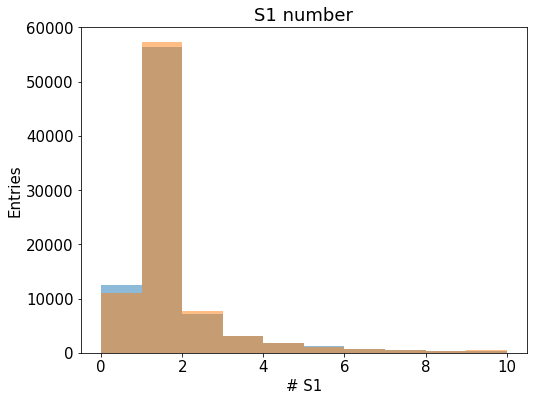

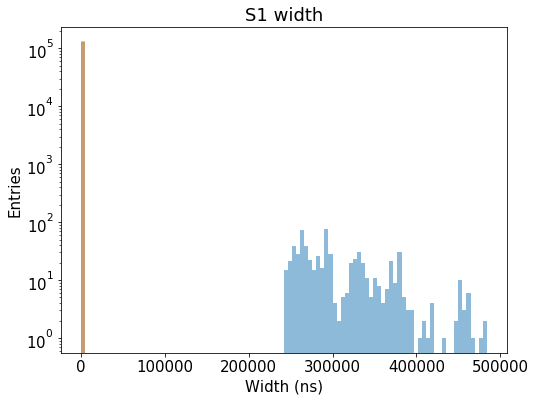

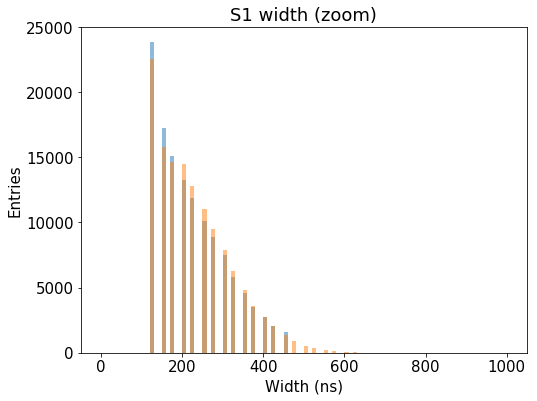

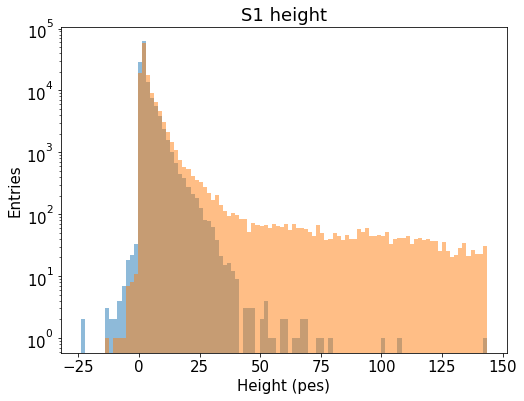

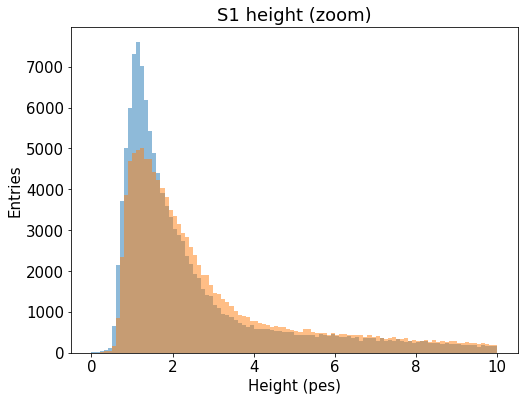

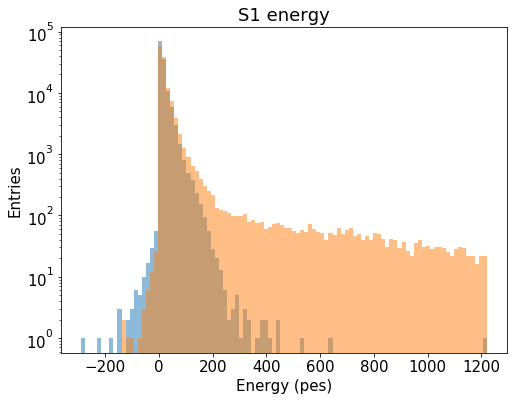

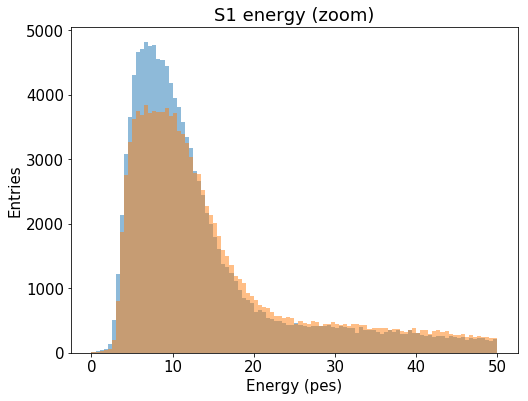

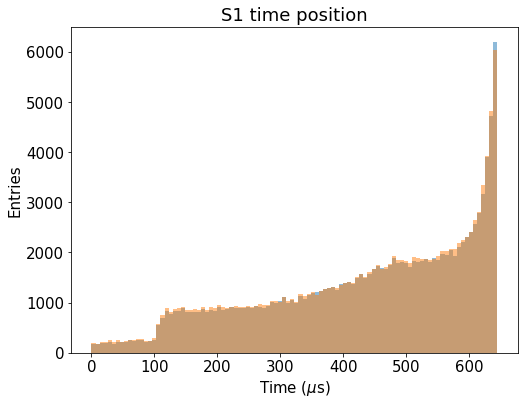

In [19]:
CreatePlotsS(np.asarray(s1n), np.asarray(s1w), np.asarray(s1h), np.asarray(s1e), \
            np.asarray(s1t)/1000., np.asarray(s1n_o), np.asarray(s1w_o), np.asarray(s1h_o), np.asarray(s1e_o), \
            np.asarray(s1t_o)/1000., "S1", minS1, maxS1)

### S2 plots

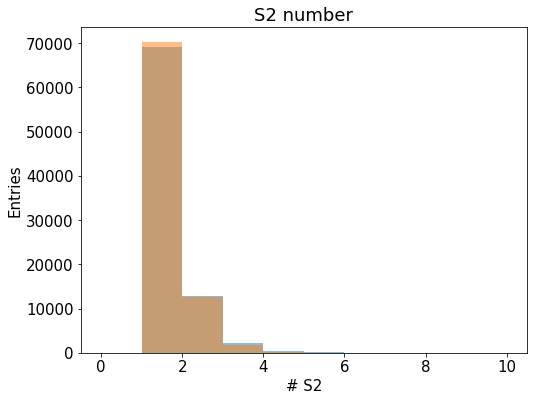

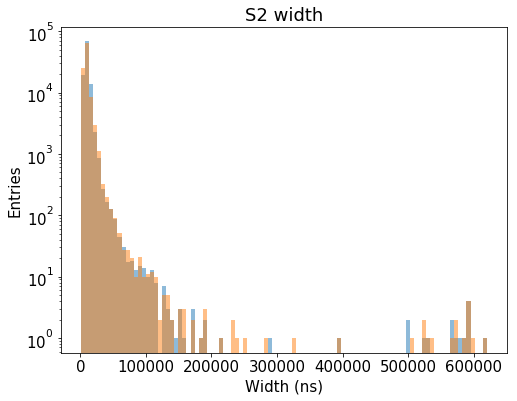

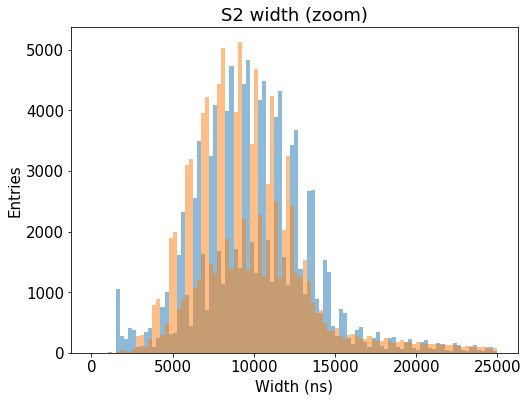

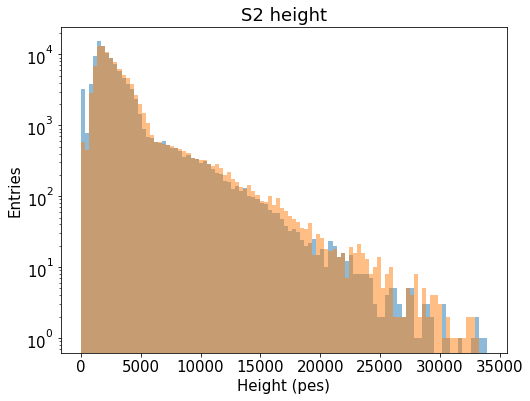

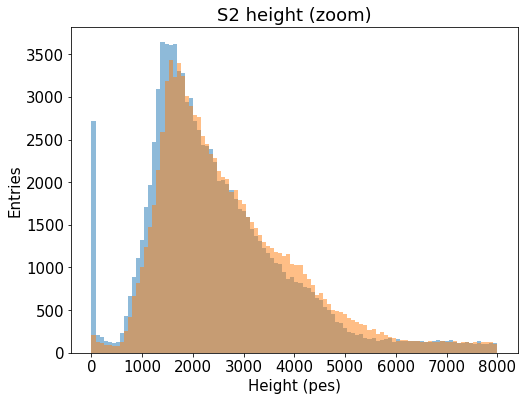

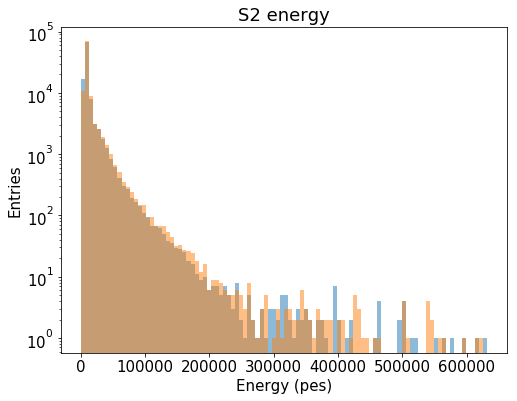

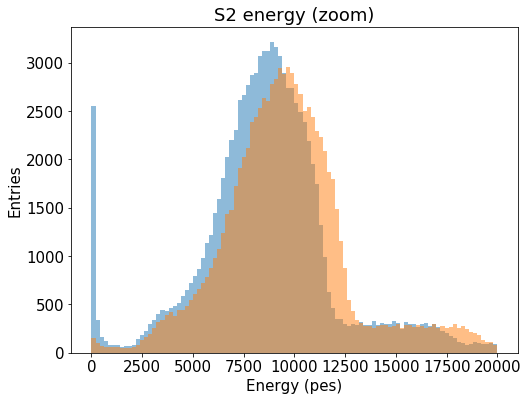

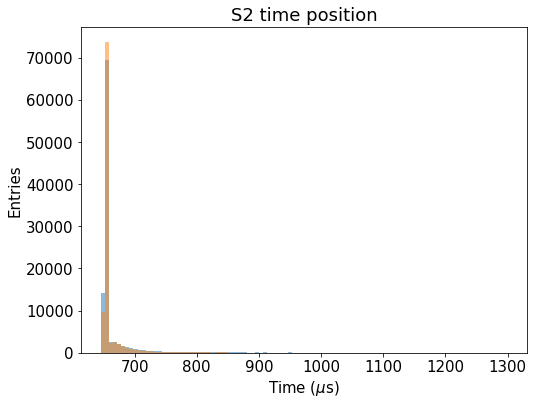

In [20]:
CreatePlotsS(np.asarray(s2n), np.asarray(s2w), np.asarray(s2h), np.asarray(s2e), \
             np.asarray(s2t)/1000., np.asarray(s2n_o), np.asarray(s2w_o), np.asarray(s2h_o), np.asarray(s2e_o), \
             np.asarray(s2t_o)/1000., "S2", minS2, maxS2)

### S2Si plots

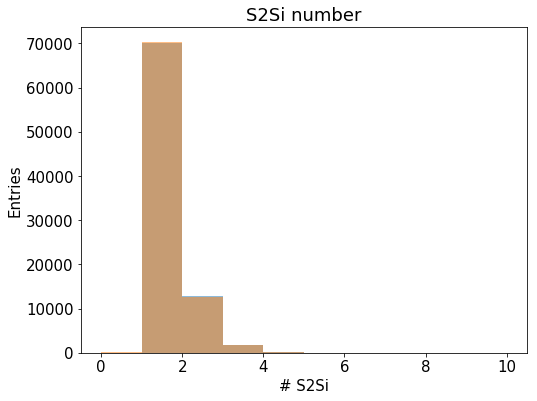

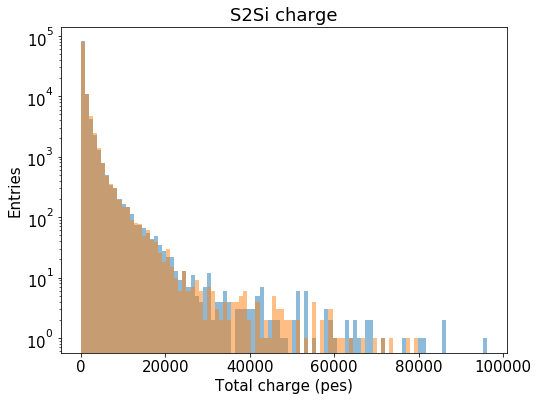

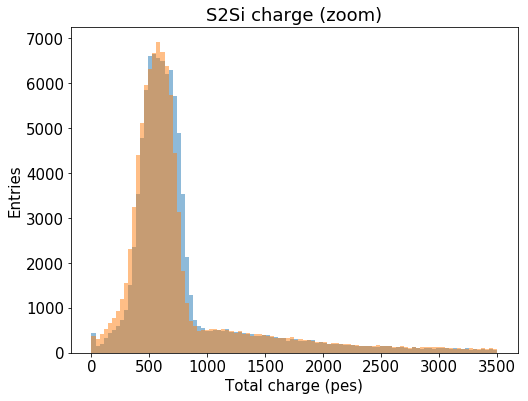

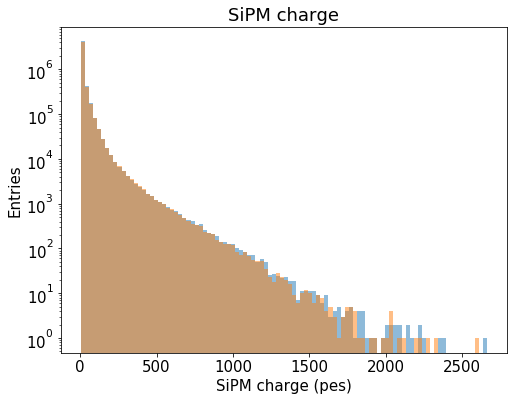

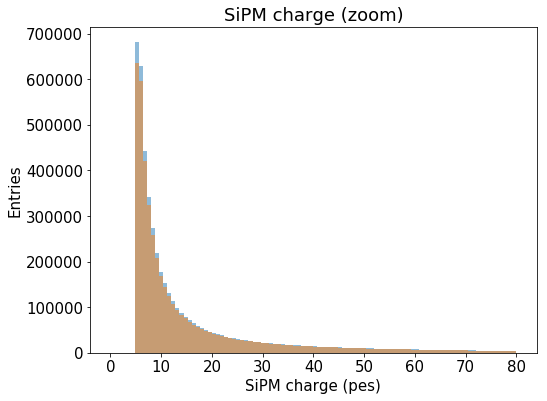

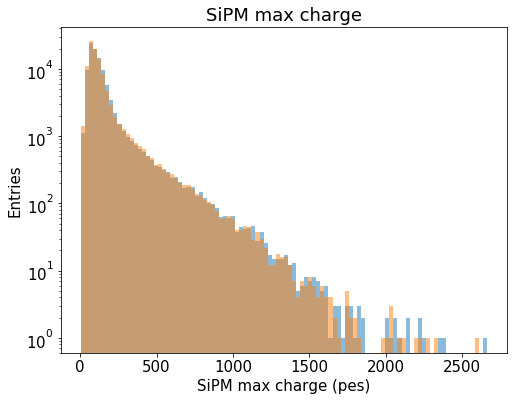

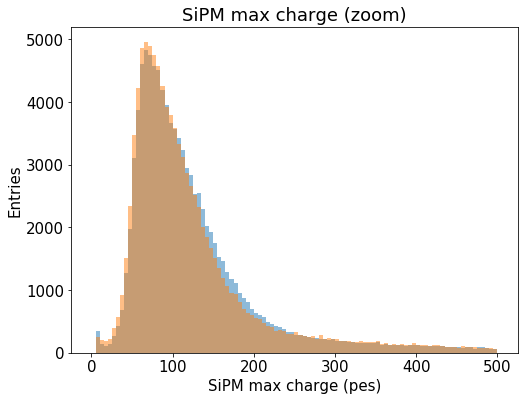

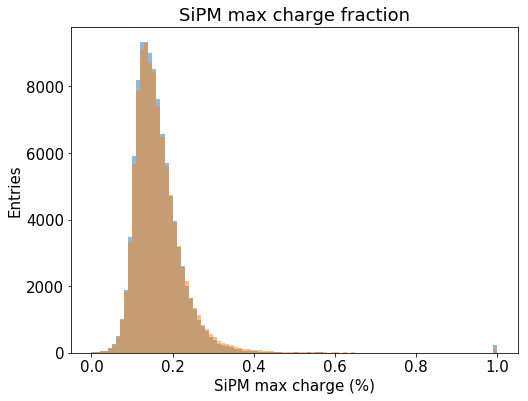

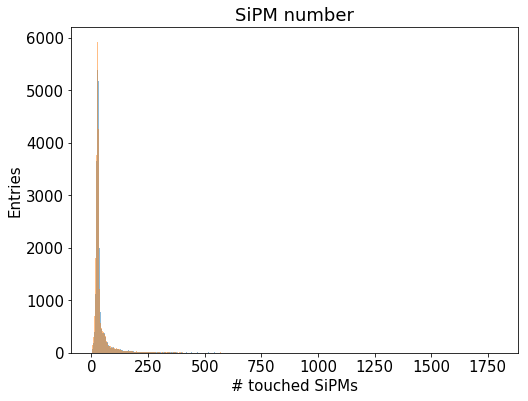

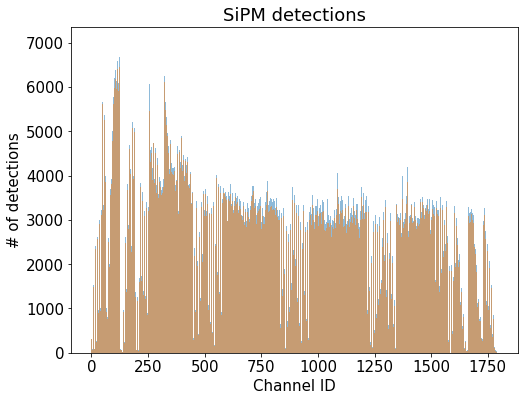

In [21]:
CreatePlotsSi(np.asarray(s2sin), np.asarray(s2q), np.asarray(s2siID), np.asarray(s2qi), \
            np.asarray(s2qmax), np.asarray(s2nsipm), np.asarray(s2sin_o), np.asarray(s2q_o), np.asarray(s2siID_o), \
              np.asarray(s2qi_o), np.asarray(s2qmax_o), np.asarray(s2nsipm_o), minS2Si, maxS2Si)

### Ratio plots

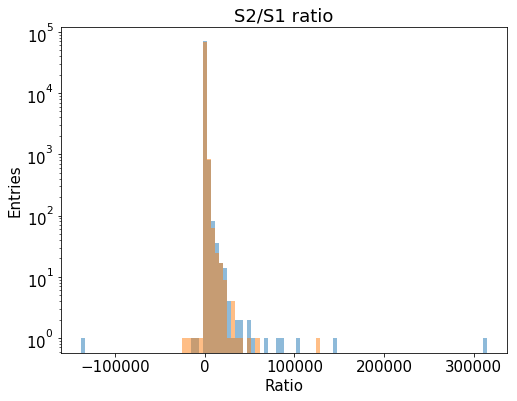

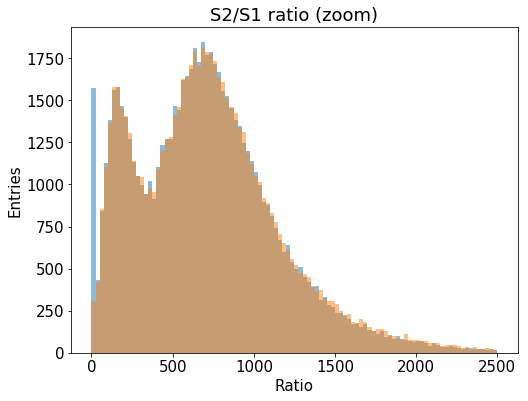

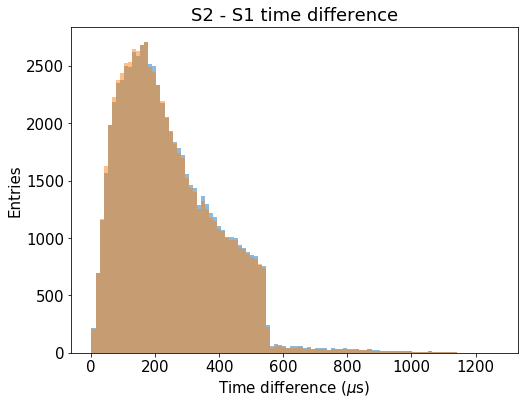

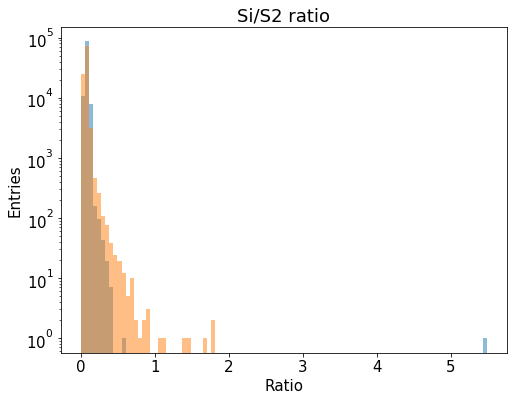

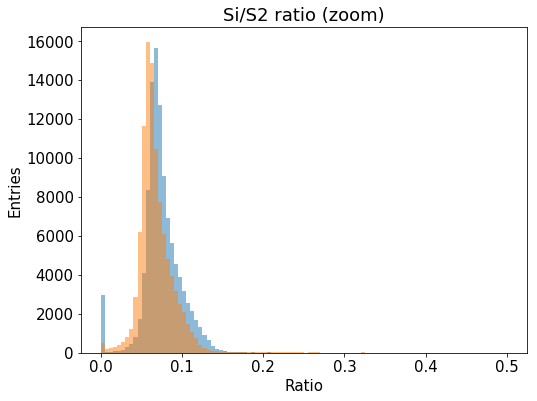

In [22]:
CreatePlotsS1S2Si(np.asarray(s2e), np.asarray(s2_s1_e), np.asarray(s2_s1_t)/1000., \
                  np.asarray(s2_s2si_e), np.asarray(s2e_o), np.asarray(s2_s1_e_o), \
                  np.asarray(s2_s1_t_o)/1000., np.asarray(s2_s2si_e_o), minRatio, maxRatio)